In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49) 
[GCC 7.5.0]
3.0.1


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [3]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
%%time

twitter_df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/abharathsingh/lsh_df')


CPU times: user 4.85 ms, sys: 93 µs, total: 4.94 ms
Wall time: 7.11 s


In [6]:
twitter_df.count()

16863979

In [7]:
original = twitter_df.withColumn("retweeted_status", when(twitter_df.retweeted_status.isNull(), twitter_df.retweeted_status))

In [8]:
original

text,Organization,id,retweeted_status
rt @sahealth: twi...,Other,1453450037011181568,null
cigarette sales i...,Other,1453450036793257984,null
rt @nytimes: merc...,Influencer,1453450037481115650,null
rt @billgates: go...,Other,1453450037757833218,null
rt @carlossimanca...,Other,1453450037946634240,null
post covid? we ar...,Other,1453450039121039360,null
rt @angie_rasmuss...,Other,1453450039439863820,null
rt @pn_1984: we a...,Other,1453450040605880327,null
@sharla_evans @hu...,Other,1453450040685518857,null
.@govchrissununu ...,Other,1453450041692200960,null


In [11]:
celebrity_raw = original.filter(original.Organization == 'Celebrity')

In [12]:
celebrity_raw

text,Organization,id,retweeted_status
rt @rawstory: 'a ...,Celebrity,1452701828253028357,null
aaron rodgers nev...,Celebrity,1455978411642527746,null
rt @gabbystern: h...,Celebrity,1455978441942077446,null
rt @ap: several h...,Celebrity,1455779189219463173,null
rt @odpp_ke: the ...,Celebrity,1455779324565544962,null
you're vaccinated...,Celebrity,1449137947417071621,null
@dmward23 vermont...,Celebrity,1453850285152083971,null
rt @tompelissero:...,Celebrity,1453850502559457281,null
pope's swiss guar...,Celebrity,1451309697097740297,null
biden moves to va...,Celebrity,1451309815876161538,null


In [13]:
celebrity_raw2 = celebrity_raw.select(['text'])

In [14]:
celebrity_raw2.printSchema()

root
 |-- text: string (nullable = true)



In [16]:
text = celebrity_raw2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [17]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
[rt @docsinecapul...,3265
[rt @joyannreid: ...,3266
[rt @neontaster: ...,3267
[same with covid ...,3268
[rt @juliahb1: wa...,3269


In [18]:
df_text.count()

11286

In [19]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[rt, @rawstory:, 'a, new, low':, missouri, paper, slams, josh, hawley, for, 'cynical, and, dangerous', stunt, that’s, 'making, the, covid, crisis, worse', https:…]",0
1,"[aaron, rodgers, never, told, the, media, he, got, the, covid, shot., but, now, they, are, saying, he, lied, to, them?, https://t.co/vyhivdtbdy]",1
2,"[rt, @gabbystern:, hi,, @who's, process, for, assessing, #covid19, vaccines, for, emergency, use, listing, is, rigorous,, scientific, and, standardized., it, i…]",2
3,"[rt, @ap:, several, high-profile, school, board, candidates, who, fought, covid-19, restrictions, and, critical, race, thoery, lost, their, election, bids., th…]",3
4,"[rt, @odpp_ke:, the, kenya, editors, guild, covid-19, handbook, for, journalists, was, officially, launched, during, the, international, day, to, end, impurity…]",4


In [20]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [21]:
df_tokens.count()

11286

In [22]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [23]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,"[rt, @rawstory:, 'a, new, low':, missouri, paper, slams, josh, hawley, for, 'cynical, and, dangerous', stunt, that’s, 'making, the, covid, crisis, worse', https:…]",0,"(1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[aaron, rodgers, never, told, the, media, he, got, the, covid, shot., but, now, they, are, saying, he, lied, to, them?, https://t.co/vyhivdtbdy]",1,"(2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[rt, @gabbystern:, hi,, @who's, process, for, assessing, #covid19, vaccines, for, emergency, use, listing, is, rigorous,, scientific, and, standardized., it, i…]",2,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[rt, @ap:, several, high-profile, school, board, candidates, who, fought, covid-19, restrictions, and, critical, race, thoery, lost, their, election, bids., th…]",3,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[rt, @odpp_ke:, the, kenya, editors, guild, covid-19, handbook, for, journalists, was, officially, launched, during, the, international, day, to, end, impurity…]",4,"(2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [24]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [25]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
80,[rt @corey_feldma...,"[rt, @corey_feldm...","(36008,[0,1,3,10,...","[[1.8678956E7], [..."
622,[breaking: @us_fd...,"[breaking:, @us_f...","(36008,[4,8,21,39...","[[1.19094037E8], ..."
774,[get the vaccines...,"[get, the, vaccin...","(36008,[0,2,6,17,...","[[9408.0], [2.091..."
778,[children can be ...,"[children, can, b...","(36008,[0,17,24,5...","[[4.7945584E7], [..."
807,[@msale18 that sh...,"[@msale18, that, ...","(36008,[2,3,5,12,...","[[2.61390943E8], ..."


In [27]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [28]:
df_dups_50 = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.000000,116,8040,"(rt @jburnmurdoch: one of the most startling covid charts i’ve made in a long time, on vaccine inequality:\n\nrich countries have given out mo…,)","(rt @jburnmurdoch: one of the most startling covid charts i’ve made in a long time, on vaccine inequality:\n\nrich countries have given out mo…,)"
1,0.000000,9100,10624,"(rt @tankschottle: am gonna speak to my heart i never want anyone to get covid i love you i care about you i want to be with you to support…,)","(rt @tankschottle: am gonna speak to my heart i never want anyone to get covid i love you i care about you i want to be with you to support…,)"
2,0.000000,3885,5309,"(rt @tedcruz: maybe firing doctors &amp; nurses—during a pandemic—because of an authoritarian vaccine mandate wasn’t the best idea…,)","(rt @tedcruz: maybe firing doctors &amp; nurses—during a pandemic—because of an authoritarian vaccine mandate wasn’t the best idea…,)"
3,0.300000,6666,7085,"(running average daily covid cases per 100,000 people, by manitoba health region, as of wednesday:\n\nsouthern: 27.9\nn… https://t.co/4jxdbguhmr,)","(running average daily covid cases per 100,000 people, by manitoba health region, as of monday:\n\nnorthern: 27.6\nsout… https://t.co/ycsht72awk,)"
4,0.090909,6945,7597,"($100 grocery gift cards for adults who get fully vaccinated using our #phx mobile #covid19 vans. we are still offer… https://t.co/7icfxpbhsh,)","($100 grocery gift cards for adults who get fully vaccinated using our #phx mobile #covid19 vans. we are still offer… https://t.co/uyho1ewym7,)"


In [29]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  11286
Duplicate titles based on { 0.5 } jaccard distance:  2211
Unique titles based on { 0.5 } jaccard distance:  0.5 :  9075


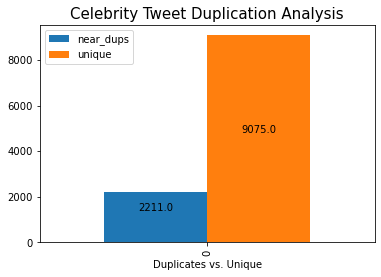

In [31]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Celebrity Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 